In [2]:
import modern_robotics as mr
import sympy as sp
from sympy import*
from sympy.physics.mechanics import dynamicsymbols, mechanics_printing
mechanics_printing()
from Utilities.symbolicFunctions import *


### Utilities


In [5]:


# def exp3(omega, theta):
#     omega = skew(omega)
#     R = sp.eye(3) + sp.sin(theta) * omega + (1 - sp.cos(theta)) * omega * omega
#     return R

# def skew(v):
#     return Matrix([[0, -v[2], v[1]],
#                     [v[2], 0, -v[0]],
#                     [-v[1], v[0], 0]])
                    
# def exp6(twist, theta):
#     omega = skew(twist[:3])
#     v = Matrix(twist[3:])
#     T = eye(4)
#     T[:3,:3] = exp3(twist[:3], theta)
#     T[:3,3] = (eye(3) * theta + (1 - cos(theta)) * omega +
#               (theta-sin(theta)) * omega * omega) * v
#     return T

# def Ad(T):
#     AdT = sp.zeros(6)
#     R = sp.Matrix(T[:3, :3])
#     AdT[:3, :3] = R
#     AdT[3:, 3:] = R
#     AdT[3:, :3] = skew(T[:3, 3]) * R
#     return AdT

# def rotX(alfa_im1):
#     Rx = sp.eye(4)
#     Rx[1,1] =    sp.cos(alfa_im1)
#     Rx[1,2] =   -sp.sin(alfa_im1)
#     Rx[2,1] =    sp.sin(alfa_im1)
#     Rx[2,2] =    sp.cos(alfa_im1)
#     return Rx

# def rotZ(alfa_im1):
#     Rz = sp.eye(4)
#     Rz[0,0] =    sp.cos(alfa_im1)
#     Rz[0,1] =   -sp.sin(alfa_im1)
#     Rz[1,0] =    sp.sin(alfa_im1)
#     Rz[1,1] =    sp.cos(alfa_im1)
#     return Rz

# def transX(a_im1):
#     trA = sp.eye(4)
#     trA[0,3] =  a_im1
#     return trA

# def transZ(d_i):
#     trA = sp.eye(4)
#     trA[2,3] =  d_i
#     return trA


# TASK 2

Task 1:


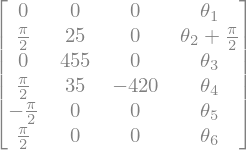

In [10]:
# Oppg 1
print("Task 1:")

th1, th2, th3, th4, th5, th6 = dynamicsymbols('theta_1, theta_2, theta_3, theta_4, theta_5, theta_6')

config = sp.Matrix([[sp.pi,0,0,th1],[sp.pi/2,25,0,th2 + sp.pi/2],[0,455,0,th3],[sp.pi/2, 35, -420, th4],[-sp.pi/2,0,0,th5],[sp.pi/2, 0, 0,th6]])
config

In [53]:
# oopg 1 Sicilliano
# a alfa    d   v
# sic_conf = sp.Matrix([[0,0,0,th1], [25,sp.pi/2,0,th2+sp.pi/2], [455,0,0,th3], [35,sp.pi/2,-420,th4], [0,-sp.pi/2,0,th5], [0,sp.pi/2,-80,th6]])
# sic_conf

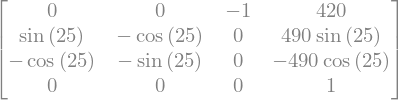

In [11]:
# oppg 2
Mi = sp.Matrix([[sp.eye(4)]*6])

for i in range(6):
    if i == 2:
        Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2]) * rotZ(-sp.pi/2) # We compansate for the rotation of -pi/2 done when finding the D-H parameters 
    else:
        Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2])

M = sp.eye(4)
for n in range(5,-1,-1):
    M = Mi[:,4*n:4*(n+1)] * M


M

In [67]:
# oppg 2 # Snart siciliano
# Mi = sp.Matrix([[sp.eye(4)]*6])

# for i in range(6):
#     if i == 1:
#         Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2]) #* rotZ(-sp.pi/2) # We compansate for the rotation of -pi/2 done when finding the D-H parameters 
#     else:
#         Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2])

# M = sp.eye(4)
# for n in range(5,-1,-1):
#     M = Mi[:,4*n:4*(n+1)] * M


# M


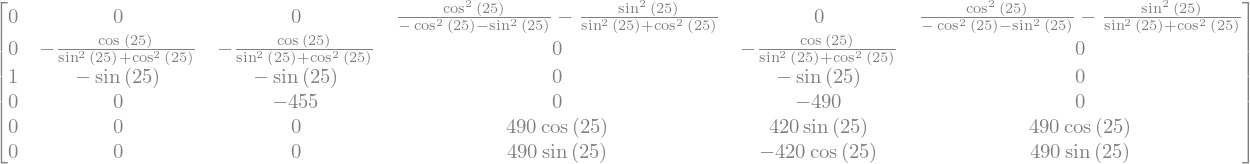

In [12]:
# oppg 3
Ai = sp.Matrix([[0,-1,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]]) # This is a given matrix due to revolute joints

S_sp = sp.zeros(6)
for i in range(6):
    dot_sum = sp.eye(4)
    for n in range(i,-1,-1):
        dot_sum = Mi[:,4*n:4*(n+1)] * dot_sum
    S_skew = dot_sum * Ai * sp.Inverse(dot_sum)
    S_sp[0,i] = S_skew[2,1] 
    S_sp[1,i] = S_skew[0,2] 
    S_sp[2,i] = S_skew[1,0] 
    S_sp[3,i] = S_skew[0,3] 
    S_sp[4,i] = S_skew[1,3]
    S_sp[5,i] = S_skew[2,3] 

S_sp

Matrix([[-1, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1, 0], [0, 0, 0, 1, 0, 1], [0, -875, -420, 0, 0, 0], [-900, 0, 0, 0, 0, 0], [0, -35, -35, 0, 0, 0]])


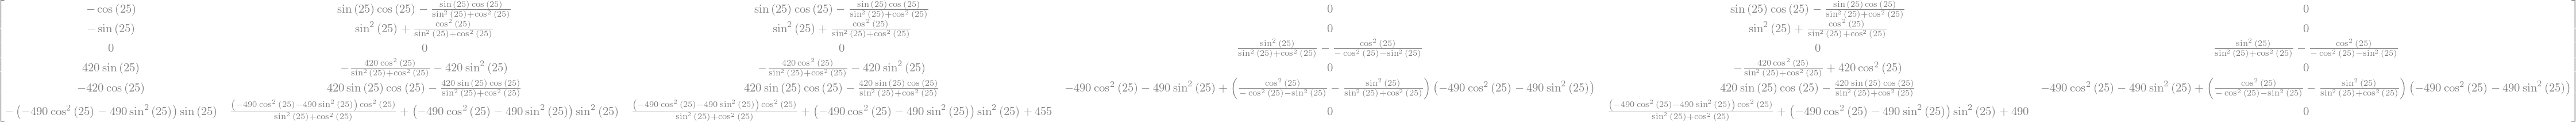

In [13]:
# oppg 4, find body frame screw axis, S_bp

M_inv = mr.TransInv(M)          #Finding inverse of M
Ad_M_inv = mr.Adjoint(M_inv)    #Computing [Ad_M^-1]

#Using B_i = [Ad_M^-1]S_i
S_bp = sp.zeros(6,6)
for i in range(6):
     S_bp[:, i] = Ad_M_inv * S_sp[:, i]

print(S_bp)
S_bp

### 2.5 Visualization

In [1]:
from Utilities.RobotClass import*
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
#DH frames:

Mlist_DH = np.zeros((6,4,4))      #Finding M01, M02..., from DH formulation Mi
Mlist_DH
M = sp.eye(4)
for i in range(6):          
    M = M * Mi[:,4*i:4*(i+1)]
    Mlist_DH[i] = M
Mlist_DH
Kuka_DH = Robot(Mlist_DH,['x','x','x','y','z','z'])
Kuka_DH.draw_robot()


NameError: name 'Mi' is not defined

In [5]:
from Utilities.kukaKinematics import Mlist, Slist
KukaOffset = Robot(Mlist, ['z', '-z', 'x', 'x', '-z','x'])

In [6]:
KukaOffset.draw_robot()

WebVisualizer(window_uid='window_1')

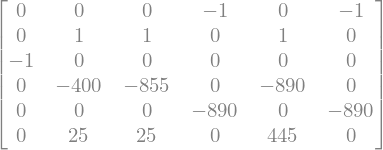

In [21]:


M1=sp.Matrix([[0, 1, 0, 0],
             [1, 0, 0, 0],
             [0, 0, -1, 200], 
             [0, 0, 0, 1]])

M2=sp.Matrix([[0, 1, 0, 25],
             [0, 0, 1, 0],
             [1, 0, 0, 400],
             [0, 0, 0, 1]])

M3=sp.Matrix([[1, 0, 0, 25],
             [0, 0, 1, 0],
             [0, -1, 0, 855],
             [0, 0, 0, 1]])
             
M4=sp.Matrix([[0, 0, -1, 25+420],
             [0, 1, 0, 0],
             [1, 0, 0, 400+455+35],
             [0, 0, 0, 1]])
M5=sp.Matrix([[1, 0, 0, 25+420],
             [0, 0, 1, 0],
             [0, -1, 0, 400+455+35],
             [0, 0, 0, 1]])
M6=sp.Matrix([[0, 0, -1, 525], 
             [0, 1, 0, 0],
             [1, 0, 0, 400+455+35],
             [0, 0, 0, 1]])
Mlist = np.array([M1,M2,M3,M4,M5,M6], dtype=float)

om = sp.zeros(3,6)
om1 = om[:, 0] = M1[:3, 2]
om2 = om[:, 1] = M2[:3, 2]
om3 = om[:, 2] = M3[:3, 2]
om4 = om[:, 3] = M4[:3, 2]
om5 = om[:, 4] = M5[:3, 2]
om6 = om[:, 5] = M6[:3, 2]
q = sp.zeros(3,6)
q1 = q[:,0] = M1[:3, 3]
q2 = q[:,1] = M2[:3, 3]
q3 = q[:,2] = M3[:3, 3]
q4 = q[:,3] = M4[:3, 3]
q5 = q[:,4] = M5[:3, 3]
q6 = q[:,5] = M6[:3, 3]

Slist = Slist_maker(om,q)
Slist

In [22]:
Kuka = Robot(Mlist, ['z', '-z', 'x', 'x', 'z','x'] )
Kuka.draw_robot()


WebVisualizer(window_uid='window_7')

In [16]:
Kuka.transform(Slist,[-1.1416,  1.038 , -4.2855, -1.5708,  1.5708, -0.2475])
Kuka.draw_robot()

WebVisualizer(window_uid='window_2')

In [17]:
Kuka.transform(Slist,[-1.1416, -1.3258,  1.3102, -1.5708,  1.5708,  2.9844])
Kuka.draw_robot()

WebVisualizer(window_uid='window_3')